In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib as mpl 
mpl.rcParams['figure.dpi'] = 400 # figure dots per inch
%matplotlib inline

import seaborn as sns
sns.set()

from datetime import datetime, timedelta

In [3]:
# Load transactions (all data including March)  
transactions_df = pd.read_pickle('Data/transactions_clean.pickle')
transactions_df.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_date_dt,membership_expire_date_dt
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0,2015-09-30,2015-10-31
10,bQkbrEPdMfVfdsoz0RoWSmgYpHJuhRqtIml7aRUrFL8=,39,30,149,149,1,20150930,20151121,0,2015-09-30,2015-11-21
24,qNpZJ7gsMPAFSvc5V3kgqtFfUQU2SZe7XSUYOAfqtoA=,40,30,149,149,1,20151001,20151101,0,2015-10-01,2015-11-01
26,WnxdSgeK3Vg4BIaioJQYilnL+E1SDxq+PZIwmmfTwgM=,34,0,0,149,1,20150930,20151031,0,2015-09-30,2015-10-31
27,ir1jh/vWZ932FpSC2WeMxdOHQ+OkuUo3ZPQs8Ms4J9g=,34,0,0,149,1,20150930,20151031,0,2015-09-30,2015-10-31


Let's reduce high cardinality features:

In [4]:
payment_id_freq = transactions_df['payment_method_id'].value_counts(normalize=True)
payment_id_freq.round(4)

41    0.6177
40    0.1105
38    0.0601
37    0.0536
34    0.0439
36    0.0399
33    0.0199
31    0.0147
39    0.0102
30    0.0062
29    0.0050
27    0.0030
35    0.0030
32    0.0026
28    0.0024
23    0.0021
18    0.0009
19    0.0008
14    0.0007
20    0.0007
16    0.0005
24    0.0004
22    0.0003
25    0.0003
26    0.0001
11    0.0001
13    0.0001
21    0.0001
17    0.0001
10    0.0001
12    0.0001
15    0.0000
8     0.0000
5     0.0000
6     0.0000
3     0.0000
2     0.0000
4     0.0000
Name: payment_method_id, dtype: float64

In [5]:
# 80-20 rule - reduce cardinality
bottom_payment_id = payment_id_freq.quantile(q=0.8)
less_freq_payment_id = payment_id_freq[payment_id_freq <= bottom_payment_id]
less_freq_payment_id.round(4)

39    0.0102
30    0.0062
29    0.0050
27    0.0030
35    0.0030
32    0.0026
28    0.0024
23    0.0021
18    0.0009
19    0.0008
14    0.0007
20    0.0007
16    0.0005
24    0.0004
22    0.0003
25    0.0003
26    0.0001
11    0.0001
13    0.0001
21    0.0001
17    0.0001
10    0.0001
12    0.0001
15    0.0000
8     0.0000
5     0.0000
6     0.0000
3     0.0000
2     0.0000
4     0.0000
Name: payment_method_id, dtype: float64

In [6]:
transactions_df.loc[transactions_df['payment_method_id'].isin(less_freq_payment_id.index.tolist()), 'payment_method_id'] = 'other'
transactions_df['payment_method_id'] = transactions_df['payment_method_id'].apply(lambda x: "{}{}".format('payment_method_id_', x))
transactions_df['payment_method_id']

1              payment_method_id_41
10          payment_method_id_other
24             payment_method_id_40
26             payment_method_id_34
27             payment_method_id_34
                     ...           
22962291       payment_method_id_36
22965803       payment_method_id_40
22965957       payment_method_id_40
22967796       payment_method_id_36
22974713       payment_method_id_40
Name: payment_method_id, Length: 13664286, dtype: object

Let's also add some features:

In [7]:
transactions_df['plan_duration'] = (transactions_df['membership_expire_date_dt'] - 
                                  transactions_df['transaction_date_dt'])

transactions_df['plan_duration'] = transactions_df['plan_duration'].astype('timedelta64[D]')
transactions_df['plan_duration'].head()

1     31.0
10    52.0
24    31.0
26    31.0
27    31.0
Name: plan_duration, dtype: float64

In [8]:
transactions_df['plan_duration'].value_counts()

 31.0     5416123
 30.0     4778706
 29.0     1023662
 32.0      900127
 28.0      289981
           ...   
-54.0           1
-118.0          1
-112.0          1
-127.0          1
-235.0          1
Name: plan_duration, Length: 1070, dtype: int64

In [9]:
transactions_df[transactions_df['plan_duration'] < 0].head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_date_dt,membership_expire_date_dt,plan_duration
422,Xik55GiZKTkU1fMHNuROOSIRjf67/9HQ9xYn7Ltldmk=,payment_method_id_other,30,149,149,1,20160225,20160224,1,2016-02-25,2016-02-24,-1.0
482,ZcPtzHBvgbuQHg3Gx9O4+QX4LK+35NXZSyEUcIbL134=,payment_method_id_37,30,149,149,1,20160826,20160825,1,2016-08-26,2016-08-25,-1.0
505,q7zVHl6rWbLoKUj3FCHSjO2caWkhhKskVfxPRyLBOHo=,payment_method_id_36,30,180,180,1,20160908,20160907,1,2016-09-08,2016-09-07,-1.0
513,iEqhCo9ehvlVGXTEm02F4oSarbJUa3IWP13gRD7BFL0=,payment_method_id_36,30,180,180,1,20170211,20170210,1,2017-02-11,2017-02-10,-1.0
550,sj2G673Oo9mUgQGg1zsN6Cxx6YmSWurMqaoNrsJ50DU=,payment_method_id_40,30,149,149,1,20161225,20161224,1,2016-12-25,2016-12-24,-1.0


In [10]:
transactions_df[transactions_df['plan_duration'] > 0].head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_date_dt,membership_expire_date_dt,plan_duration
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,payment_method_id_41,30,149,149,1,20150930,20151031,0,2015-09-30,2015-10-31,31.0
10,bQkbrEPdMfVfdsoz0RoWSmgYpHJuhRqtIml7aRUrFL8=,payment_method_id_other,30,149,149,1,20150930,20151121,0,2015-09-30,2015-11-21,52.0
24,qNpZJ7gsMPAFSvc5V3kgqtFfUQU2SZe7XSUYOAfqtoA=,payment_method_id_40,30,149,149,1,20151001,20151101,0,2015-10-01,2015-11-01,31.0
26,WnxdSgeK3Vg4BIaioJQYilnL+E1SDxq+PZIwmmfTwgM=,payment_method_id_34,0,0,149,1,20150930,20151031,0,2015-09-30,2015-10-31,31.0
27,ir1jh/vWZ932FpSC2WeMxdOHQ+OkuUo3ZPQs8Ms4J9g=,payment_method_id_34,0,0,149,1,20150930,20151031,0,2015-09-30,2015-10-31,31.0


Negative values in plan_duration imply the membership was canceled (is_canceled = 1).

In [11]:
transactions_df['credit'] = (transactions_df['actual_amount_paid'] - transactions_df['plan_list_price'])
transactions_df['credit'].value_counts()

 0       12883088
 149       473082
-30        202774
-149        58159
 119        17611
 129        17348
 150         4127
-180         2002
-20          1959
-50          1155
 894          742
 134          623
 100          469
 1788         406
-120          151
 35           131
 131          114
 536           63
 480           48
 300           47
 799           45
 1599          40
 30            27
 450           13
 447           10
 930            9
 1000           9
 350            6
 500            5
 105            5
-108            4
-1              4
 400            2
 1150           2
 760            1
 50             1
 41             1
-699            1
 12             1
 1              1
Name: credit, dtype: int64

In [12]:
transactions_df['transaction_credit'] = np.where(transactions_df['credit'] == 0, 
                                                 'even', 
                                                 np.where(transactions_df['credit'] > 0, 
                                                          'credit', 'debit'))

## Generate Test Set

Current day is April 1st, we consider members which exp date is in March and potentially churn in April.
So transactions are until end of March - this will serve as test dataset.

In [13]:
current_day = datetime(2017, 4, 1)
#transactions_df = transactions_df[(transactions_df['transaction_date_dt'] < current_day) &
#                                 (transactions_df['membership_expire_date_dt'] < current_day)].reset_index(drop=True)
transactions_df = transactions_df[(transactions_df['transaction_date_dt'] < current_day)].reset_index(drop=True)
transactions_df.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_date_dt,membership_expire_date_dt,plan_duration,credit,transaction_credit
0,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,payment_method_id_41,30,149,149,1,20150930,20151031,0,2015-09-30,2015-10-31,31.0,0,even
1,bQkbrEPdMfVfdsoz0RoWSmgYpHJuhRqtIml7aRUrFL8=,payment_method_id_other,30,149,149,1,20150930,20151121,0,2015-09-30,2015-11-21,52.0,0,even
2,qNpZJ7gsMPAFSvc5V3kgqtFfUQU2SZe7XSUYOAfqtoA=,payment_method_id_40,30,149,149,1,20151001,20151101,0,2015-10-01,2015-11-01,31.0,0,even
3,WnxdSgeK3Vg4BIaioJQYilnL+E1SDxq+PZIwmmfTwgM=,payment_method_id_34,0,0,149,1,20150930,20151031,0,2015-09-30,2015-10-31,31.0,149,credit
4,ir1jh/vWZ932FpSC2WeMxdOHQ+OkuUo3ZPQs8Ms4J9g=,payment_method_id_34,0,0,149,1,20150930,20151031,0,2015-09-30,2015-10-31,31.0,149,credit


In [14]:
transactions_df.shape

(13664286, 14)

In [15]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13664286 entries, 0 to 13664285
Data columns (total 14 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   msno                       object        
 1   payment_method_id          object        
 2   payment_plan_days          int16         
 3   plan_list_price            int16         
 4   actual_amount_paid         int16         
 5   is_auto_renew              int16         
 6   transaction_date           int64         
 7   membership_expire_date     int64         
 8   is_cancel                  int16         
 9   transaction_date_dt        datetime64[ns]
 10  membership_expire_date_dt  datetime64[ns]
 11  plan_duration              float64       
 12  credit                     int16         
 13  transaction_credit         object        
dtypes: datetime64[ns](2), float64(1), int16(6), int64(2), object(3)
memory usage: 990.4+ MB


In [16]:
transactions_df.describe()

,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,plan_duration,credit
count,1.366429e+07,1.366429e+07,1.366429e+07,1.366429e+07,1.366429e+07,1.366429e+07,1.366429e+07,1.366429e+07,1.366429e+07
mean,2.992232e+01,1.317261e+02,1.362609e+02,9.047002e-01,2.015808e+07,2.015916e+07,1.788714e-02,3.444479e+01,4.534741e+00
std,1.756192e+01,7.888522e+01,7.586549e+01,2.936286e-01,5.617590e+03,6.083125e+03,1.325413e-01,3.742646e+01,3.257340e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015010e+07,2.015010e+07,0.000000e+00,-3.570000e+02,-6.990000e+02
25%,3.000000e+01,9.900000e+01,9.900000e+01,1.000000e+00,2.015103e+07,2.015121e+07,0.000000e+00,3.000000e+01,0.000000e+00
50%,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.016050e+07,2.016061e+07,0.000000e+00,3.100000e+01,0.000000e+00
75%,3.000000e+01,1.490000e+02,1.490000e+02,1.000000e+00,2.016093e+07,2.016103e+07,0.000000e+00,3.100000e+01,0.000000e+00
max,4.500000e+02,2.000000e+03,2.000000e+03,1.000000e+00,2.017030e+07,2.017023e+07,1.000000e+00,7.830000e+02,1.788000e+03


In [17]:
transactions_df['days_since_last_transaction_date'] = current_day - transactions_df['transaction_date_dt']
transactions_df['days_since_last_transaction_date'] = transactions_df['days_since_last_transaction_date'].astype('timedelta64[D]')
transactions_df['days_since_membership_expire_date'] = current_day - transactions_df['membership_expire_date_dt']
transactions_df['days_since_membership_expire_date'] = transactions_df['days_since_membership_expire_date'].astype('timedelta64[D]')

In [18]:
transactions_df[['msno',
                 'transaction_date_dt', 
                 'days_since_last_transaction_date',
                 'membership_expire_date_dt', 
                 'days_since_membership_expire_date',
                 'is_auto_renew']].sort_values(by='msno').head()

,msno,transaction_date_dt,days_since_last_transaction_date,membership_expire_date_dt,days_since_membership_expire_date,is_auto_renew
37103,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2017-01-15,76.0,2017-02-15,45.0,1
950309,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2016-11-16,136.0,2016-12-15,107.0,1
11365513,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2016-12-15,107.0,2017-01-15,76.0,1
11979389,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2016-01-26,431.0,2016-02-26,400.0,1
3634544,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2015-09-26,553.0,2015-10-26,523.0,1


In [19]:
transactions_df['expired_and_not_auto_renew'] = np.where(
    (transactions_df.is_auto_renew == 0) & (transactions_df.days_since_membership_expire_date > 0), 1, 0
).astype(np.int8)
transactions_df['expired_and_not_auto_renew'].value_counts()

0    12362082
1     1302204
Name: expired_and_not_auto_renew, dtype: int64

Create features summarizing the last transaction:

In [20]:
transactions_df_sorted = transactions_df.sort_values(['msno','membership_expire_date_dt'], ascending=False).reset_index(drop = True)
transactions_df_sorted

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_date_dt,membership_expire_date_dt,plan_duration,credit,transaction_credit,days_since_last_transaction_date,days_since_membership_expire_date,expired_and_not_auto_renew
0,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,payment_method_id_41,30,99,99,1,20170104,20170204,0,2017-01-04,2017-02-04,31.0,0,even,87.0,56.0,0
1,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,payment_method_id_41,30,99,99,1,20170202,20170202,1,2017-02-02,2017-02-02,0.0,0,even,58.0,58.0,0
2,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,payment_method_id_41,30,99,99,1,20161204,20170104,0,2016-12-04,2017-01-04,31.0,0,even,118.0,87.0,0
3,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,payment_method_id_41,30,99,99,1,20161104,20161204,0,2016-11-04,2016-12-04,30.0,0,even,148.0,118.0,0
4,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,payment_method_id_41,30,99,99,1,20161004,20161104,0,2016-10-04,2016-11-04,31.0,0,even,179.0,148.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13664281,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,payment_method_id_41,30,149,149,1,20150226,20150326,0,2015-02-26,2015-03-26,28.0,0,even,765.0,737.0,0
13664282,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,payment_method_id_41,30,149,149,1,20150126,20150226,0,2015-01-26,2015-02-26,31.0,0,even,796.0,765.0,0
13664283,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,payment_method_id_41,30,99,99,1,20170115,20170215,0,2017-01-15,2017-02-15,31.0,0,even,76.0,45.0,0
13664284,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,payment_method_id_41,30,99,99,1,20161215,20170115,0,2016-12-15,2017-01-15,31.0,0,even,107.0,76.0,0


In [21]:
last_transactions_df = transactions_df_sorted.drop_duplicates(subset='msno', keep='first')
last_transactions_df.columns = last_transactions_df.columns + '_last'
last_transactions_df = last_transactions_df.rename(columns={'msno_last': 'msno'})
last_transactions_df

,msno,payment_method_id_last,payment_plan_days_last,plan_list_price_last,actual_amount_paid_last,is_auto_renew_last,transaction_date_last,membership_expire_date_last,is_cancel_last,transaction_date_dt_last,membership_expire_date_dt_last,plan_duration_last,credit_last,transaction_credit_last,days_since_last_transaction_date_last,days_since_membership_expire_date_last,expired_and_not_auto_renew_last
0,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,payment_method_id_41,30,99,99,1,20170104,20170204,0,2017-01-04,2017-02-04,31.0,0,even,87.0,56.0,0
12,zzxqpgPX1epGyR3SVRKb3XitWdt+JqDURxV5ea1D7Cg=,payment_method_id_other,100,480,480,0,20161022,20170130,0,2016-10-22,2017-01-30,100.0,0,even,161.0,61.0,1
32,zzxi7n5xoTYo9Q3VTygLWvl/rBDcexwaeAry0yK7Q0E=,payment_method_id_41,30,99,99,1,20170118,20170218,0,2017-01-18,2017-02-18,31.0,0,even,73.0,42.0,0
35,zzxZeMFx2fjfKZigMnJa2w0EmloDbm8+8nTf/o/00GY=,payment_method_id_41,30,99,99,1,20170126,20170226,0,2017-01-26,2017-02-26,31.0,0,even,65.0,34.0,0
60,zzx7wcys2Nha6yP2Skjs+R1/JNAfEuAWUaAp0qsV2Cg=,payment_method_id_41,30,99,99,1,20161111,20170209,1,2016-11-11,2017-02-09,90.0,0,even,141.0,51.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13664221,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,payment_method_id_38,30,149,149,0,20170124,20170223,0,2017-01-24,2017-02-23,30.0,0,even,67.0,37.0,1
13664236,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,payment_method_id_41,30,149,149,1,20170120,20170220,0,2017-01-20,2017-02-20,31.0,0,even,71.0,40.0,0
13664247,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,payment_method_id_41,30,149,149,1,20170115,20170215,0,2017-01-15,2017-02-15,31.0,0,even,76.0,45.0,0
13664258,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,payment_method_id_41,30,149,149,1,20170126,20170226,0,2017-01-26,2017-02-26,31.0,0,even,65.0,34.0,0


Let's create other features by grouping and aggregating:  

In [22]:
transactions_sum_df = transactions_df.copy()
transactions_sum_df.columns

Index(['msno', 'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel', 'transaction_date_dt',
       'membership_expire_date_dt', 'plan_duration', 'credit',
       'transaction_credit', 'days_since_last_transaction_date',
       'days_since_membership_expire_date', 'expired_and_not_auto_renew'],
      dtype='object')

In [23]:
to_drop = ['transaction_date',
           'membership_expire_date', 
           'transaction_date_dt', 
           'membership_expire_date_dt',
           'days_since_last_transaction_date',
           'days_since_membership_expire_date',
           ]
transactions_sum_df.drop(to_drop, axis=1, inplace=True)

In [24]:
transactions_sum_df = transactions_sum_df.groupby('msno').sum().reset_index()
transactions_sum_df.columns = transactions_sum_df.columns + '_sum' 
transactions_sum_df = transactions_sum_df.rename(columns={'msno_sum': 'msno'})

In [25]:
transactions_sum_df['overall_credit'] = np.where(transactions_sum_df['credit_sum'] == 0, 
                                             'even', np.where(transactions_sum_df['credit_sum'] > 0, 
                                                              'credit', 'debit'))

In [26]:
transactions_sum_df.head()

,msno,payment_plan_days_sum,plan_list_price_sum,actual_amount_paid_sum,is_auto_renew_sum,is_cancel_sum,plan_duration_sum,credit_sum,expired_and_not_auto_renew_sum,overall_credit
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,90,297,297,3,0,91.0,0,0,even
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,720,3576,3725,25,0,762.0,149,0,credit
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,330,1639,1639,11,0,337.0,0,0,even
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,330,1639,1639,11,0,337.0,0,0,even
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,517,2414,2414,0,0,550.0,0,15,even


In [27]:
transactions_count_df = transactions_df.groupby('msno')['is_cancel'].count().reset_index()
transactions_count_df.rename(columns={'is_cancel': 'transactions_count'}, inplace=True)
transactions_count_df.head()

,msno,transactions_count
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,3
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,25
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,11
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,11
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,15


In [28]:
transactions_mean_df = transactions_df.copy()
transactions_mean_df = transactions_mean_df.groupby('msno').mean().reset_index()
transactions_mean_df.columns = transactions_mean_df.columns + '_mean' 
transactions_mean_df = transactions_mean_df.rename(columns={'msno_mean': 'msno'})

transactions_mean_df.head()

,msno,payment_plan_days_mean,plan_list_price_mean,actual_amount_paid_mean,is_auto_renew_mean,transaction_date_mean,membership_expire_date_mean,is_cancel_mean,plan_duration_mean,credit_mean,days_since_last_transaction_date_mean,days_since_membership_expire_date_mean,expired_and_not_auto_renew_mean
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,30.000000,99.000000,99.000000,1.0,2.016415e+07,2.016718e+07,0.0,30.333333,0.00,106.333333,76.000000,0.0
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,28.800000,143.040000,149.000000,1.0,2.015625e+07,2.015706e+07,0.0,30.480000,5.96,431.320000,400.840000,0.0
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,30.000000,149.000000,149.000000,1.0,2.016162e+07,2.016252e+07,0.0,30.636364,0.00,229.000000,198.363636,0.0
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,30.000000,149.000000,149.000000,1.0,2.016162e+07,2.016252e+07,0.0,30.636364,0.00,224.000000,193.363636,0.0
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,34.466667,160.933333,160.933333,0.0,2.015800e+07,2.015929e+07,0.0,36.666667,0.00,370.933333,334.266667,1.0


In [29]:
transactions_median_df = transactions_df.copy()
transactions_median_df = transactions_median_df.groupby('msno').median().reset_index()
transactions_median_df.columns = transactions_median_df.columns + '_median' 
transactions_median_df = transactions_median_df.rename(columns={'msno_median': 'msno'})

transactions_median_df.head()

,msno,payment_plan_days_median,plan_list_price_median,actual_amount_paid_median,is_auto_renew_median,transaction_date_median,membership_expire_date_median,is_cancel_median,plan_duration_median,credit_median,days_since_last_transaction_date_median,days_since_membership_expire_date_median,expired_and_not_auto_renew_median
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,30.0,99.0,99.0,1.0,20161215.0,20170115.0,0.0,31.0,0.0,107.0,76.0,0.0
1,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,30.0,149.0,149.0,1.0,20160126.0,20160226.0,0.0,31.0,0.0,431.0,400.0,0.0
2,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,30.0,149.0,149.0,1.0,20160815.0,20160915.0,0.0,31.0,0.0,229.0,198.0,0.0
3,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,30.0,149.0,149.0,1.0,20160820.0,20160920.0,0.0,31.0,0.0,224.0,193.0,0.0
4,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,30.0,149.0,149.0,0.0,20160320.0,20160419.0,0.0,30.0,0.0,377.0,347.0,1.0


In [30]:
(last_transactions_df.shape, 
 transactions_sum_df.shape, 
 transactions_count_df.shape,
 transactions_mean_df.shape,
 transactions_median_df.shape)

((934535, 17), (934535, 10), (934535, 2), (934535, 13), (934535, 13))

In [31]:
train = pd.read_csv('sample_submission_v2.csv')

In [32]:
train.shape

(907471, 2)

In [33]:
train.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0


In [34]:
transactions_apr = pd.merge(train, last_transactions_df, on='msno', how='left')
transactions_apr = pd.merge(transactions_apr, transactions_sum_df, on='msno', how='left')
transactions_apr = pd.merge(transactions_apr, transactions_count_df, on='msno', how='left')
transactions_apr = pd.merge(transactions_apr, transactions_mean_df, on='msno', how='left')
transactions_apr = pd.merge(transactions_apr, transactions_median_df, on='msno', how='left')

In [35]:
transactions_apr.drop('is_churn', axis=1, inplace=True)

In [36]:
transactions_apr.head()

,msno,payment_method_id_last,payment_plan_days_last,plan_list_price_last,actual_amount_paid_last,is_auto_renew_last,transaction_date_last,membership_expire_date_last,is_cancel_last,transaction_date_dt_last,...,actual_amount_paid_median,is_auto_renew_median,transaction_date_median,membership_expire_date_median,is_cancel_median,plan_duration_median,credit_median,days_since_last_transaction_date_median,days_since_membership_expire_date_median,expired_and_not_auto_renew_median
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,payment_method_id_41,30.0,99.0,99.0,1.0,20170118.0,20170218.0,0.0,2017-01-18,...,99.0,1.0,20160418.0,20160518.0,0.0,31.0,0.0,348.0,318.0,0.0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,payment_method_id_34,30.0,149.0,149.0,1.0,20170131.0,20170228.0,0.0,2017-01-31,...,149.0,1.0,20160331.0,20160430.0,0.0,31.0,0.0,366.0,336.0,0.0
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,payment_method_id_41,30.0,99.0,99.0,1.0,20170115.0,20170215.0,0.0,2017-01-15,...,99.0,1.0,20150712.0,20150811.0,0.0,30.0,-30.0,629.0,599.0,0.0
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,payment_method_id_41,30.0,99.0,99.0,1.0,20170127.0,20170227.0,0.0,2017-01-27,...,99.0,1.0,20160627.0,20160727.0,0.0,31.0,0.0,278.0,248.0,0.0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,payment_method_id_other,30.0,129.0,129.0,1.0,20170122.0,20170221.0,0.0,2017-01-22,...,129.0,1.0,20165672.0,20170171.0,0.0,30.0,0.0,84.5,54.5,0.0


In [37]:
transactions_apr.shape

(907471, 51)

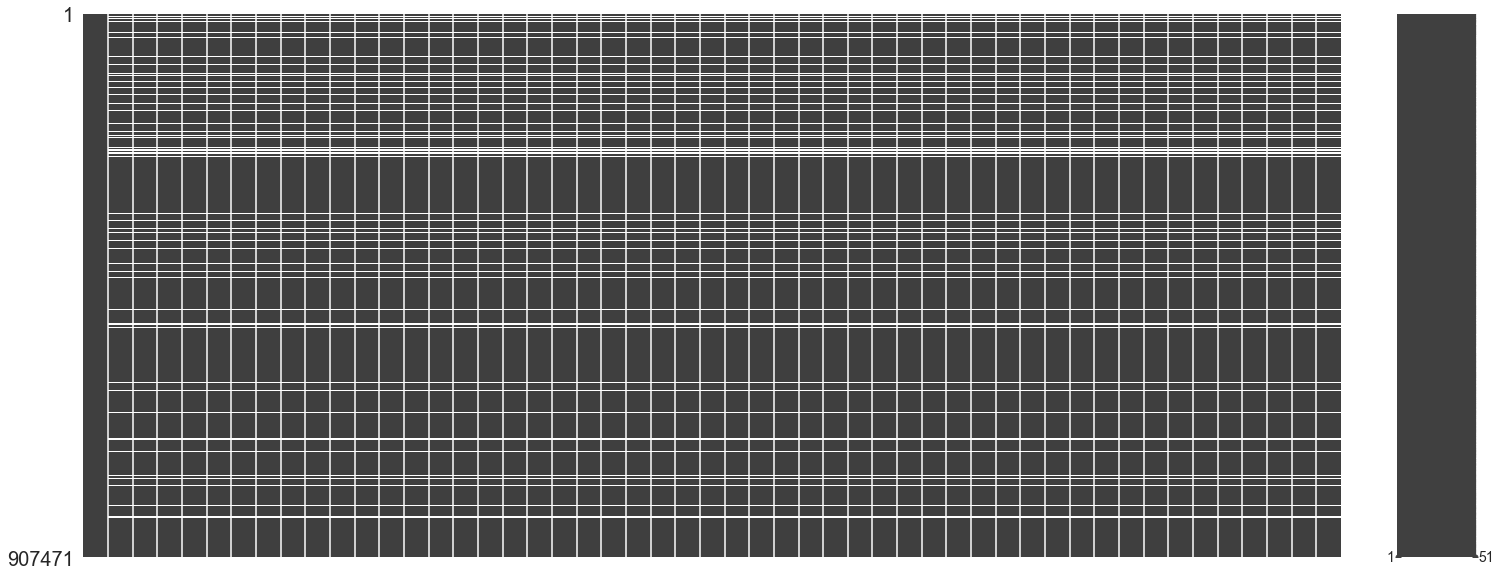

In [38]:
import missingno as ms

ms.matrix(transactions_apr)
plt.tight_layout()
#plt.savefig('missing values.png')

In [39]:
import pickle

with open('Data/Processed/transactions_apr.pickle', 'wb') as handle:
    pickle.dump(transactions_apr, handle)